<a href="https://colab.research.google.com/github/wolfinwallst/Financial_Engineering_and_Risk_Management/blob/main/Greeks_via_Numerical_differentiation_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[그릭을 수치 해석적인 방법으로 해결하기](https://sine-qua-none.tistory.com/233) 에서 발췌했다.

1. 파생상품의 가격이 콜옵션/풋옵션처럼 closed-form으로 정해진 경우가 아니라면, (-> MC/FDM/이항트리(binomial tree)로 계산)
2. 또는 미분값을 구하기 어려운 경우 혹은 계산의 단순화/효율화를 위해서

아래와 같이 수치해석적 미분(아래에선 `central difference(중앙차분법)`를 사용함)을 사용해서, 계산을 간소화할 수 있다:

Maximum difference between closed form delta and numerical delta : 0.0000148013
Maximum difference between closed form gamma and numerical gamma : 0.0000014086
Maximum difference between closed form speed and numerical speed : 0.0000000613


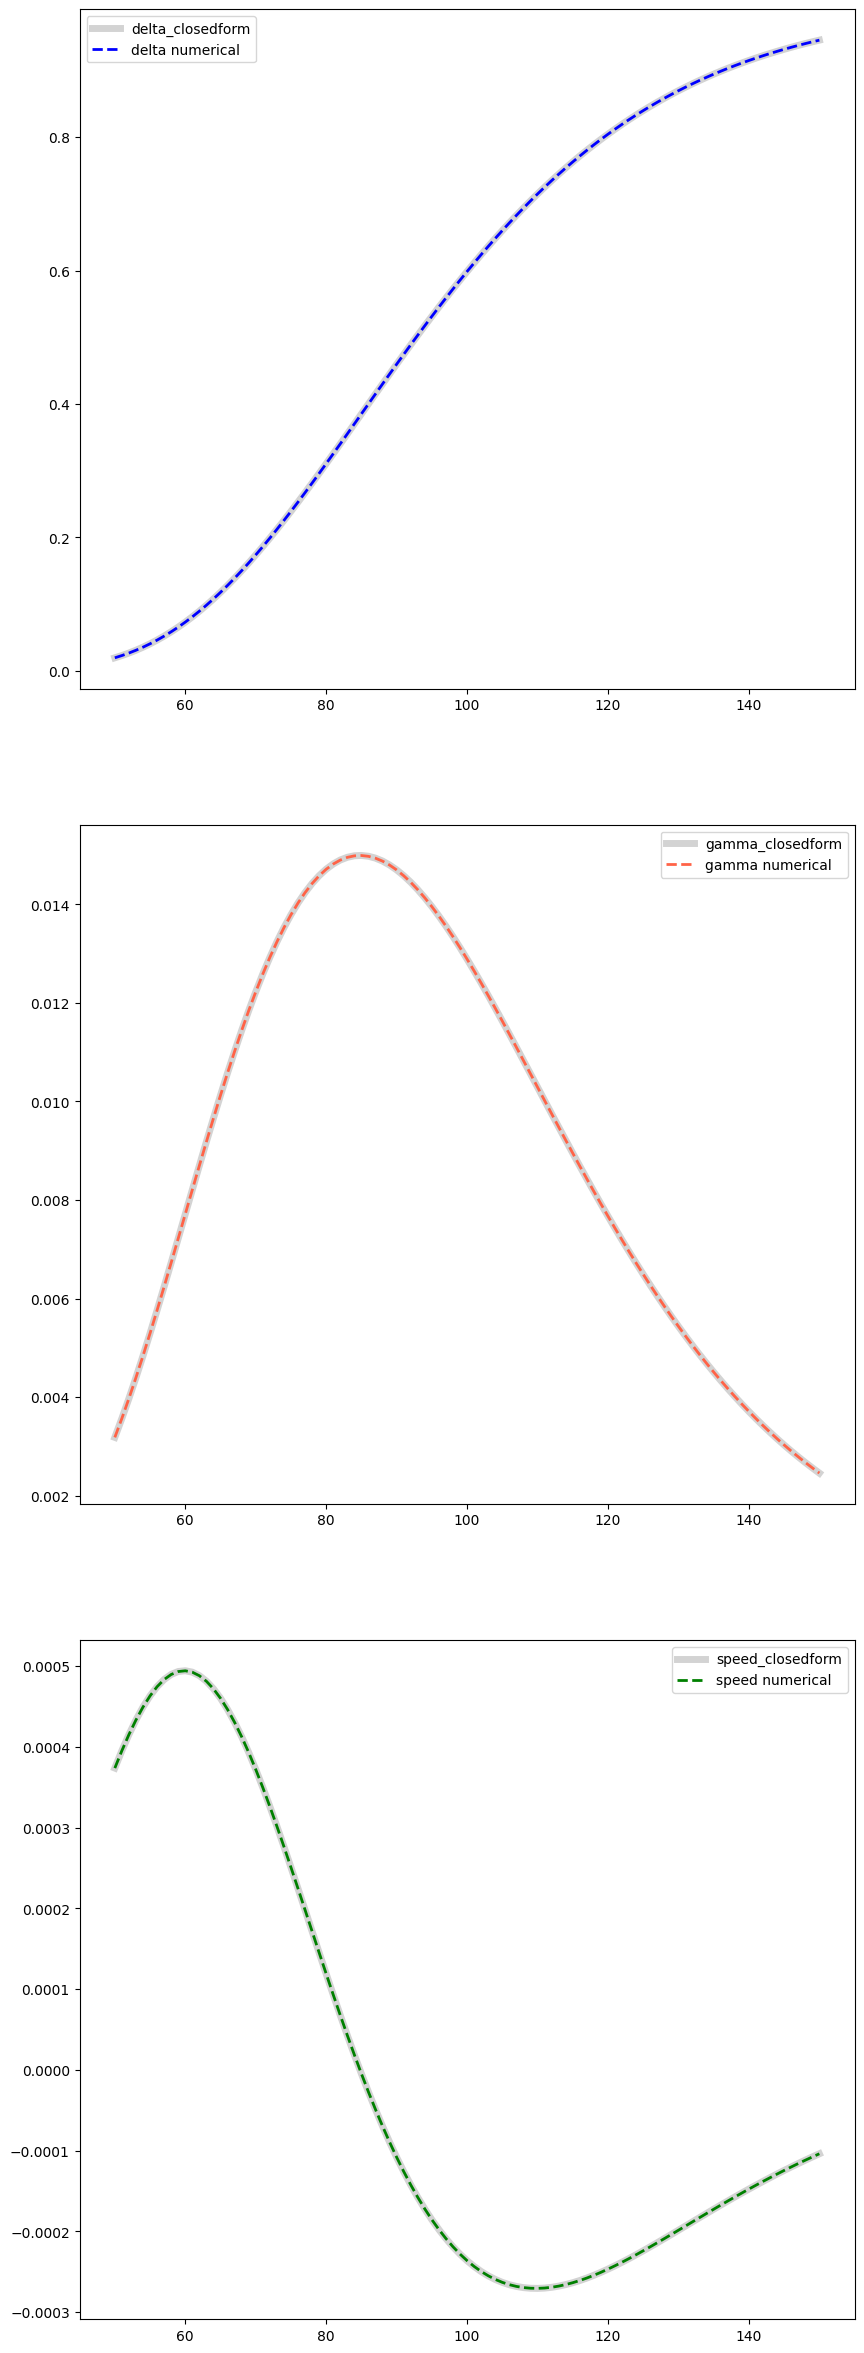

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

def CallOptionBS(S, K, T, r, q, sigma):
    Ncdf = norm.cdf
    npdf = norm.pdf

    if T == 0:
        val = np.maximum(S - K, 0)
        delta = 1 if S >= K else 0
        gamma = 0
        speed = 0
        theta = 0
        vega = 0
        volga = 0
        ultima = 0

    else:
        d1 = (np.log(S / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        val = S * np.exp(-q * T) * Ncdf(d1) - K * np.exp(-r * T) * Ncdf(d2)
        delta = np.exp(-q * T) * Ncdf(d1)
        gamma = np.exp(-q * T) * npdf(d1) / (S * sigma * np.sqrt(T))
        speed = -np.exp(-q * T) * npdf(d1) / (S ** 2 * sigma * np.sqrt(T)) * (1 + d1 / (sigma * np.sqrt(T)))
        theta = -np.exp(-q * T) * S * npdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * Ncdf(
            d2) + q * S * np.exp(-q * T) * Ncdf(d1)
        # theta2 = -(r - q) * S * delta - 0.5 * sigma ** 2 * S ** 2 * gamma + r * val
        # theta +(r-q)S *delta + 0.5*sigma^2*S^2 *gamma -rf =0
        vega = S * np.exp(-q * T) * npdf(d1) * np.sqrt(T)  # vega
        volga = vega * d1 * d2 / sigma                     # volga
        ultima = -vega / sigma ** 2 * (d1 * d2 * (1 - d1 * d2) + d1 ** 2 + d2 ** 2) #ultima

    # return index
    # 0. value
    # 1. delta
    # 2. gamma
    # 3. speed
    # 4. theta
    # 5. vega
    # 6. volga
    # 7. ultima
    return val, delta, gamma, speed, theta, vega, volga, ultima



# -----------------------------------------------------
# ---- CallOptionBS_NumericalGreeks 함수 설명 ----------
# delta, gamma, speed를 수치해석적으로 구하는 함수
# call option value 는 Black Scholes Formula를 그대로 씀
# -----------------------------------------------------
def CallOptionBS_NumericalGreeks(S, K, T, r, q, sigma):
    Ncdf = norm.cdf # 현재 numerical differentiation 함수에선 안 쓰이는 듯
    npdf = norm.pdf

    ds = 0.01 * S   # 본문의 h로 표시한 것(h=dS), S 크기의 1%를 h로 설정

    val = CallOptionBS(S, K, T, r, q, sigma)[0]
    val_up = CallOptionBS(S + ds / 2, K, T, r, q, sigma)[0]   # h/2 bumping up
    val_up2 = CallOptionBS(S + ds, K, T, r, q, sigma)[0]      # h   bumping up
    val_down = CallOptionBS(S - ds / 2, K, T, r, q, sigma)[0] # h/2 bumping down
    val_down2 = CallOptionBS(S - ds, K, T, r, q, sigma)[0]    # h   bumping down

    # 본문의 식(2), (5), (6)을 코딩한 결과
    delta = (val_up - val_down) / (ds)
    gamma = (val_up2 - 2 * val + val_down2) / (ds ** 2)
    speed = (val_up2 - 2 * val_up + 2 * val_down - val_down2) / (ds ** 3 / 4)

    # 0. value
    # 1. delta
    # 2. gamma
    # 3. speed
    return val, delta, gamma, speed


def analysis_call_option_numerical_greeks():
    s0 = 100
    strike = 100
    maturity = 1
    rfr = 0.03
    div = 0
    vol = 0.3

    spot_array = np.arange(50, 150 + 1, 1)  # 기초자산은 50~ 150까지 1간격으로 array 만듬
    delta_list = []
    gamma_list = []
    speed_list = []
    for s in spot_array:
        res_analytic = CallOptionBS(s, strike, maturity, rfr, div, vol)   # 공식으로 구한 greeks
        res_numerical = CallOptionBS_NumericalGreeks(s, strike, maturity, rfr, div, vol)
                                                                          # 수치해석적 greeks
        delta_list.append([res_analytic[1], res_numerical[1]])    # [공식 델타, 수치해석 델타] list
        gamma_list.append([res_analytic[2], res_numerical[2]])    # [공식 감마, 수치해석 감마] list
        speed_list.append([res_analytic[3], res_numerical[3]])    # [공식 speed, 수치해석 speed] list

    delta_array = np.array(delta_list)  # list의 array화 (밑에 slicing을 위하여)
    gamma_array = np.array(gamma_list)
    speed_array = np.array(speed_list)

    from matplotlib import gridspec
    fig = plt.figure(figsize=(10, 30))
    gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[1, 1, 1])
    ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])]

    # 기초자산 가격에 따른 공식 델타와, 수치해석 델타를 그래프에 같이 표시
    ax[0].plot(spot_array, delta_array[:, 0], color='lightgray', linewidth=5, label='delta_closedform')
    ax[0].plot(spot_array, delta_array[:, 1], color='blue', linewidth=2, linestyle='--', label='delta numerical')
    ax[0].legend()

    # 공식 델타와 수치해석 델타 array의 원소중 차이가 가장 큰 것을 출력
    print('Maximum difference between closed form delta and numerical delta : {:.10f}'.format(
        np.max(np.abs(delta_array[:, 1] - delta_array[:, 0]))))

    # 기초자산 가격에 따른 공식 감마와, 수치해석 감마를 그래프에 같이 표시
    ax[1].plot(spot_array, gamma_array[:, 0], color='lightgray', linewidth=5, label='gamma_closedform')
    ax[1].plot(spot_array, gamma_array[:, 1], color='tomato', linewidth=2, linestyle='--', label='gamma numerical')
    ax[1].legend()

    # 공식 감마와 수치해석 감마 array의 원소중 차이가 가장 큰 것을 출력
    print('Maximum difference between closed form gamma and numerical gamma : {:.10f}'.format(
        np.max(np.abs(gamma_array[:, 1] - gamma_array[:, 0]))))

    # 기초자산 가격에 따른 공식 스피드와, 수치해석 스피드를 그래프에 같이 표시
    ax[2].plot(spot_array, speed_array[:, 0], color='lightgray', linewidth=5, label='speed_closedform')
    ax[2].plot(spot_array, speed_array[:, 1], color='green', linewidth=2, linestyle='--', label='speed numerical')
    ax[2].legend()

    # 공식 스피드와 수치해석 스피드 array의 원소중 차이가 가장 큰 것을 출력
    print('Maximum difference between closed form speed and numerical speed : {:.10f}'.format(
        np.max(np.abs(speed_array[:, 1] - speed_array[:, 0]))))

    plt.show()

if __name__ == '__main__':
    analysis_call_option_numerical_greeks()